# INFO 2950 Final Project - Phase II
##### Janice Shen (js3678), Khai Xin Kuan (kk996), Sandy Lin (sl2534), David Park (yp358)

## Research Questions
Something we found in common between the four of us is our love for music and aspiration in finance. We wondered, can something as personal as individual music preference be somehow related to the greater US economy. This conversation sparked us to research into previous work about music sentiments and the us economy, which seems to give us very promising correlation (such as music sentiment with weekly equity: https://www.sciencedirect.com/science/article/pii/S0304405X21003718#:~:text=We%20find%20that%20music%20sentiment,when%20trading%20restrictions%20limit%20arbitrage).

However, excited as we are, we ask a range of questions, from daring to more pessimistic:

1. Can we predict the valence (a spectrum indicating negative or positive emotions, with 0 indicating most negative and 1 indicating most positive) of the general population’s music preference based on the unemployment rate, fed fund rate and other economic variables?
2. Through this journey, we also wondered how danceability correlated with valence, and subsequently, can we predict the danceability (with 0.0 being the least danceable and 1.0 being the most danceable) of the general population’s music preference based on the unemployment rate, fed fund rate and other economic variables?

Originally, we went and included all songs in our analysis and found the correlation to be extremely weak. We wondered if this was because the data included a large quantity of songs but people didn't listen to some of them, making them irrelevant. Therefore, we revised our data and filter out unpopular songs with a metric of popularity (a scale out of 100, 100 being the most popular), creating a bottleneck of 70 for our top 10000 song data. 

Even then, we saw a weak correlation and wondered if there even is a relation betwen broad music/entertainment with the economy. Does the way people consumer entertainment effect the economy at all? Thus, coming to our final research question:

3. Lastly, taking a huge step back, is there any relationship between the music industry and the economy? More specifically, we ask is there any relation between the GDP and the music/entertainment growth?

In [70]:
import pandas as pd
import numpy as np
import duckdb
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from sklearn.linear_model import LinearRegression, LogisticRegression

## Data Descriptions

○ What are the observations (rows) and the attributes (columns)?
○ Why was this dataset created?
○ Who funded the creation of the dataset?
○ What processes might have influenced what data was observed and recorded and
what was not?
○ What preprocessing was done, and how did the data come to be in the form that
you are using?
○ If people are involved, were they aware of the data collection and if so, what
purpose did they expect the data to be used for?
○ Where can your raw source data be found, if applicable? Provide a link to the raw
data (hosted on Github, in a Cornell Google Drive or Cornell Box).
We collected 4 sets of data to analyze. 

1. *First source for different elements of music sentiments (specifically testing danceability and valence)*
This file, named data.csv, was a dataset we found on calebelgut’s github that was said to be scraped directly from Spotify about songs (rows) released from 1921-2020 and different music sentiment element (columns). This data set was original produced to predict popularity from music elements and thus the popularity metric is calculated from today's popularity of a song which could be an issue comparing historic economic data (since huge hits in the 90s for example, could be not so popular today but we are comparing that song in the context of 90s economic data in our project). 
Source:https://github.com/calebelgut/spotify-lstm/tree/main/Data
 
2. *Second source for different elements of music sentiments (specifically testing danceability and valence)*
This file, named top10000song.csv, was a dataset we found on kraggle by Sean Miller who scraped the data from Billboard and ARIA (Australian Recording Industry Association) from the 1950-now, detailing 10,000 most popular Spotify songs (rows) and there music sentiment elements (columns such as Popularity, Energy, and Valence). This again was meant for music fanatics interested in the popularity of musics, but for our project, we liked how the popularity metric was measured from a historitical point of view which we compare with historical economic data (such as unemployment rate). 
Source:https://www.kaggle.com/datasets/joebeachcapital/top-10000-spotify-songs-1960-now	

4. *Source for different economic indicators (specifically testing interest rate, unemployment rate, GDP)*
This file, named Index.csv, is a dataset from kraggle by Abigail Larion, created from the Federal Reserve. This dataset contains data on economic variables such the monthly federal funds rate, real GDP, and unemployment rate from Jul 1954 - Mar 2017.  
Source:https://www.kaggle.com/datasets/federalreserve/interest-rates
 
6. *Source From Federal Reserve Bank of St. Louis about monthly unemployment rate data from Jan 1948- Sep 2024*
Source:https://fred.stlouisfed.org/series/UNRATE

7. *Source From Federal Reserve Bank of St. Louis about yearly GDP from 1997-2019*
Source: https://fred.stlouisfed.org/series/GDP

9. *Source From Federal Reserve Bank of St. Louis about yearly Music/entertainment industry GDP from 1997-2019*
Source:https://fred.stlouisfed.org/series/USPRFRMSPRTMSMNGSP


In [4]:
#load all datasets
musicdata = pd.read_csv("data.csv")
econdata = pd.read_csv("index.csv")
undata= pd.read_csv("un.csv")
songdata=pd.read_csv("top10000song.csv")

### Data Collection and Cleaning
Summary:
We begin to inspect the first 3 datasets by using .head() and .shape to ensure we have enough data. Then we check if there is any NaN value. If there is, we dropped the value. For the interest rate, since the raw data gives us each month's interest rate, we average the 12 months to a by-yearly scale. We then create a new dataset that contains the average interest rate of the year that matches the yearly scale of the music sentiments. 

After cleaning, we created a new dataframe that contains only data that we are interested in exploring the relationship such as danceability, valence, year, interest rate, and unemployment rate by using Inner Join on year (SQL). 

However, after running our analysis, we realized that there was a weak correlation and wanted another dataset to cross check. Thus, we used the top10000 songdata in the second part of this project after inspecting and analyzing the first 3 data sets with the spotify dataset of music sentiments. 

In [5]:
#understand the all musicdata we have in the dataset and check the shape to see if we have enough data
print(musicdata.head())
print(musicdata.shape)


   acousticness                                   artists  danceability  \
0         0.995                       ['Carl Woitschach']         0.708   
1         0.994  ['Robert Schumann', 'Vladimir Horowitz']         0.379   
2         0.604                   ['Seweryn Goszczyński']         0.749   
3         0.995                      ['Francisco Canaro']         0.781   
4         0.990  ['Frédéric Chopin', 'Vladimir Horowitz']         0.210   

   duration_ms  energy  explicit                      id  instrumentalness  \
0       158648  0.1950         0  6KbQ3uYMLKb5jDxLF7wYDD             0.563   
1       282133  0.0135         0  6KuQTIu1KoTTkLXKrwlLPV             0.901   
2       104300  0.2200         0  6L63VW0PibdM1HDSBoqnoM             0.000   
3       180760  0.1300         0  6M94FkXd15sOAOQYRnWPN8             0.887   
4       687733  0.2040         0  6N6tiFZ9vLTSOIxkj8qKrd             0.908   

   key  liveness  loudness  mode  \
0   10    0.1510   -12.428     1   
1    8  

In [6]:
# checking to see if we have NaN values
print("Number of music danceability: ", len(musicdata['danceability']))
print("Nan is present: ",\
      np.isnan(musicdata['danceability']).any())

Number of music danceability:  169909
Nan is present:  False


In [7]:
#understand the all econdata we have in the dataset and check the shape to see if we have enough data
print(econdata.head())
print(econdata.shape)

   Year  Month  Day  Federal Funds Target Rate  Federal Funds Upper Target  \
0  1954      7    1                        NaN                         NaN   
1  1954      8    1                        NaN                         NaN   
2  1954      9    1                        NaN                         NaN   
3  1954     10    1                        NaN                         NaN   
4  1954     11    1                        NaN                         NaN   

   Federal Funds Lower Target  Effective Federal Funds Rate  \
0                         NaN                          0.80   
1                         NaN                          1.22   
2                         NaN                          1.06   
3                         NaN                          0.85   
4                         NaN                          0.83   

   Real GDP (Percent Change)  Unemployment Rate  Inflation Rate  
0                        4.6                5.8             NaN  
1                   

In [8]:
# checking to see if we have NaN values
print("Number of rows in fed fund rate: ", len(econdata['Effective Federal Funds Rate']))
print("Nan is present: ",\
      np.isnan(econdata['Effective Federal Funds Rate']).any())

Number of rows in fed fund rate:  904
Nan is present:  True


In [9]:
#Nan vaue is found, drop it 
econdata.dropna(subset=['Effective Federal Funds Rate'], inplace=True)
print(np.isnan(econdata['Effective Federal Funds Rate']).any())
#check the shape to see if we have enough data
print(econdata.shape)


False
(752, 10)


In [10]:
#rename the Effective Federal Funds Rate col, easier without space for writing SQL later
print(econdata.columns)
econdata.rename(columns={"Effective Federal Funds Rate": "fedfundrate"}, inplace=True)
print(econdata.columns)

Index(['Year', 'Month', 'Day', 'Federal Funds Target Rate',
       'Federal Funds Upper Target', 'Federal Funds Lower Target',
       'Effective Federal Funds Rate', 'Real GDP (Percent Change)',
       'Unemployment Rate', 'Inflation Rate'],
      dtype='object')
Index(['Year', 'Month', 'Day', 'Federal Funds Target Rate',
       'Federal Funds Upper Target', 'Federal Funds Lower Target',
       'fedfundrate', 'Real GDP (Percent Change)', 'Unemployment Rate',
       'Inflation Rate'],
      dtype='object')


In [11]:
#understand the all interestdata we have in the dataset and check the shape to see if we have enough data
print(undata.head())
print(undata.shape)

         DATE  UNRATE
0  1948-01-01     3.4
1  1948-02-01     3.8
2  1948-03-01     4.0
3  1948-04-01     3.9
4  1948-05-01     3.5
(921, 2)


In [12]:
# checking to see if we have NaN values
print("Number of rows in UNRate: ", len(undata['UNRATE']))
print("Nan is present: ",\
      np.isnan(undata['UNRATE']).any())

Number of rows in UNRate:  921
Nan is present:  False


In [13]:
# in order to merge the data, we need to convert the date format into datetime

#check date type
print(undata["DATE"].dtype)
# convert to datetime format
undata['DATE']= pd.to_datetime(undata['DATE'], format='%Y-%m-%d', errors='coerce')
undata

object


,DATE,UNRATE
0,1948-01-01,3.4
1,1948-02-01,3.8
2,1948-03-01,4.0
3,1948-04-01,3.9
4,1948-05-01,3.5
...,...,...
916,2024-05-01,4.0
917,2024-06-01,4.1
918,2024-07-01,4.3
919,2024-08-01,4.2


Data manipulation: we average the interest rate and grouped by year to be the same scale as the spotify dataset. 

In [14]:
# modify econdata to find avg interestrate for each year
newundata = duckdb.sql("SELECT year(DATE) AS Year, AVG(UNRATE) AS UnemploymentRate FROM undata GROUP BY year(DATE)").df()
newundata

,Year,UnemploymentRate
0,1953,2.925000
1,1955,4.366667
2,1957,4.300000
3,1964,5.158333
4,1970,4.983333
...,...,...
72,2010,9.608333
73,2014,6.158333
74,2015,5.275000
75,2018,3.891667


In [15]:
# use sql to get a data frame with danceabilty, valence, interest rate and unemployment
cleandata= duckdb.sql("SELECT danceability, valence, musicdata.year, fedfundrate FROM\
            musicdata INNER JOIN econdata ON musicdata.year = econdata.year").df()
cleandata= duckdb.sql("SELECT danceability, valence, cleandata.year, \
        fedfundrate, UnemploymentRate FROM cleandata INNER JOIN newundata\
            ON cleandata.year = newundata.Year").df()
cleandata

,danceability,valence,year,fedfundrate,UnemploymentRate
0,0.330,0.540,1971,4.14,5.950000
1,0.652,0.921,1971,4.14,5.950000
2,0.266,0.432,1971,4.14,5.950000
3,0.239,0.292,1971,4.14,5.950000
4,0.349,0.342,1971,4.14,5.950000
...,...,...,...,...,...
1502795,0.527,0.272,2010,0.11,9.608333
1502796,0.413,0.341,2010,0.11,9.608333
1502797,0.769,0.536,2010,0.11,9.608333
1502798,0.696,0.900,2010,0.11,9.608333


### Data visualization and analysis


In [16]:
# inspect the correlation
cleandata.corr()

,danceability,valence,year,fedfundrate,UnemploymentRate
danceability,1.000000,0.551024,0.193483,-0.015057,0.045752
valence,0.551024,1.000000,-0.055054,0.109555,0.007659
year,0.193483,-0.055054,1.000000,-0.253908,0.239239
fedfundrate,-0.015057,0.109555,-0.253908,1.000000,0.060750
UnemploymentRate,0.045752,0.007659,0.239239,0.060750,1.000000


Danceability and valence has a highest correlation as what we expected. However, danceability has a weak +ve correlation with Unemployment rate (0.04) and a weak -ve correlation (-0.02) with fedfundrate. In addition, valence has an even lower +ve correlation with Unemployment rate (0.007)and Interest Rate (0.1). 


<Axes: xlabel='year', ylabel='valence'>

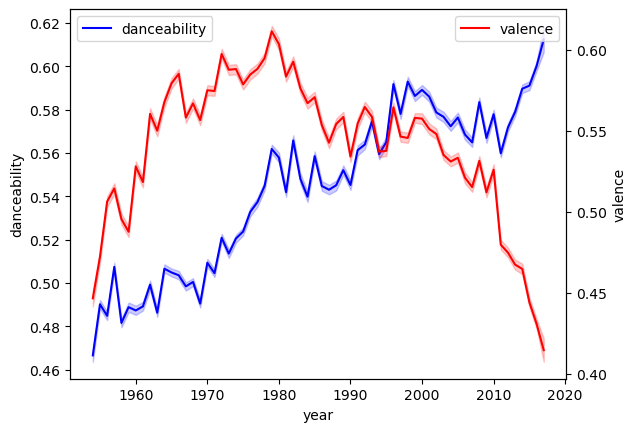

In [17]:
# visualize time series of valence and danceability across the years
fig, ax1 = plt.subplots()
sns.lineplot(x='year', y='danceability', data=cleandata, ax=ax1, color='blue', label='danceability')
ax2 = ax1.twinx()
sns.lineplot(x='year', y='valence', data=cleandata, ax=ax2, color='red', label='valence')

From the graph, we can see that the overall trend between danceability and valence is mostly similar, except for the period from 2010 onwards, where danceability increases while valence decreases. Note that both danceability and valence are the average of that year as we have multiple songs in a year from the dataset. 

<Axes: xlabel='year', ylabel='valence'>

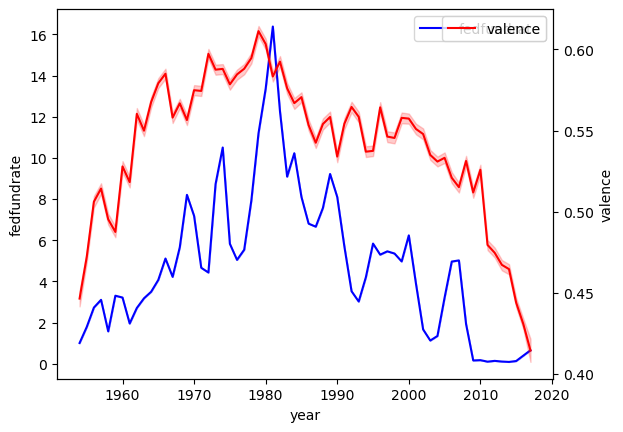

In [18]:
# visualize time series of valence and fedfundrate across the years
fig, ax1 = plt.subplots()
sns.lineplot(x='year', y='fedfundrate', data=cleandata, ax=ax1, color='blue', label='fedfundrate')
ax2 = ax1.twinx()
sns.lineplot(x='year', y='valence', data=cleandata, ax=ax2, color='red', label='valence')

<Axes: xlabel='year', ylabel='danceability'>

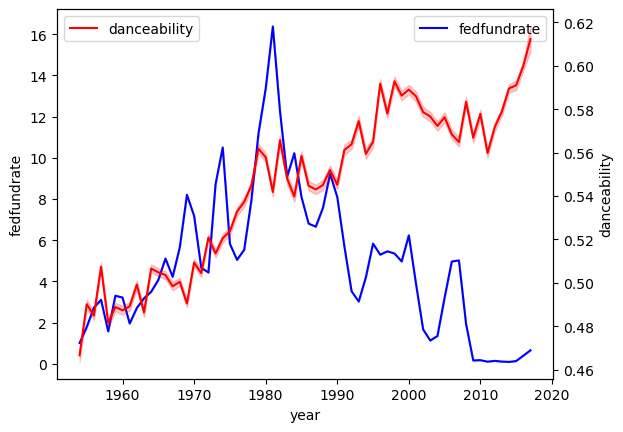

In [19]:
# visualize time series of danceability and fedfundrate across the years
fig, ax1 = plt.subplots()
sns.lineplot(x='year', y='fedfundrate', data=cleandata, ax=ax1, color='blue', label='fedfundrate')
ax2 = ax1.twinx()
sns.lineplot(x='year', y='danceability', data=cleandata, ax=ax2, color='red', label='danceability')

<Axes: xlabel='year', ylabel='valence'>

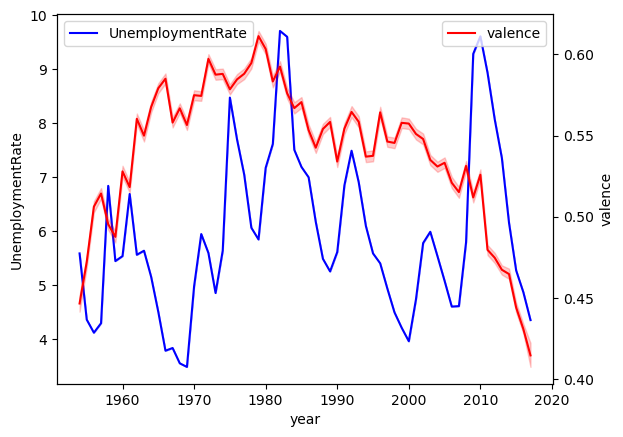

In [20]:
# visualize time series of valence and unemploymentrate across the years
fig, ax1 = plt.subplots()
sns.lineplot(x='year', y='UnemploymentRate', data=cleandata, ax=ax1, color='blue', label='UnemploymentRate')
ax2 = ax1.twinx()
sns.lineplot(x='year', y='valence', data=cleandata, ax=ax2, color='red', label='valence')

<Axes: xlabel='year', ylabel='danceability'>

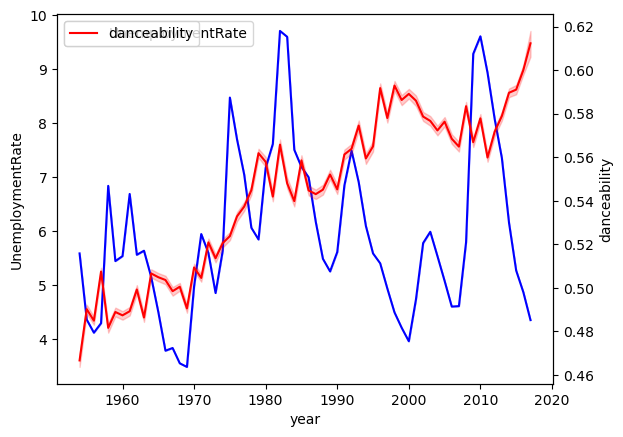

In [21]:
# visualize time series of danceability and unemploymentrate across the years
fig, ax1 = plt.subplots()
sns.lineplot(x='year', y='UnemploymentRate', data=cleandata, ax=ax1, color='blue', label='UnemploymentRate')
ax2 = ax1.twinx()
sns.lineplot(x='year', y='danceability', data=cleandata, ax=ax2, color='red', label='danceability')

Inspect why dancebility and valence has such weak correlation with fedfundrate and unemploymentrate by plotting scatter plots. 
We found out that regardless of the fed fund rate and unemployment rate, we have songs with a full spectrum of danceability and valence. This might justify why there is a week correlation. 

NOTE: we reduce the transparency of the dot to make sure we can determine overlapping to get more accurate perceptions of the fange of songs' danceability and valence. 

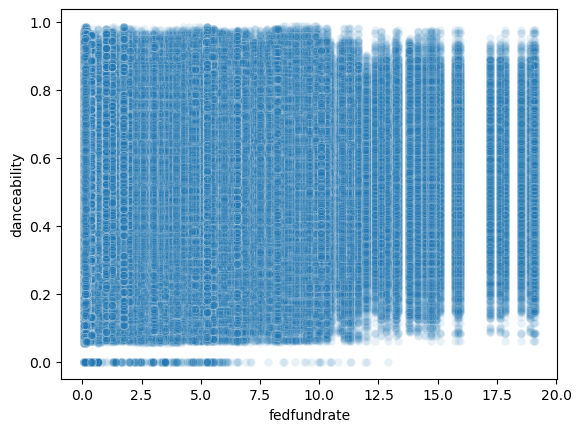

In [22]:
dance_fedfund_graph= sns.scatterplot(cleandata, x="fedfundrate", y="danceability", alpha=0.1)


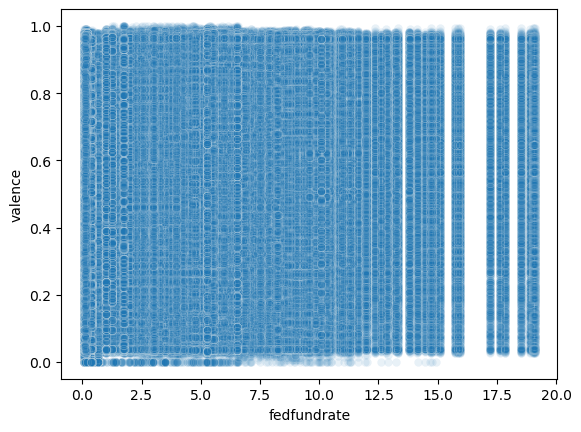

In [23]:
valence_fedfund_graph= sns.scatterplot(cleandata, x="fedfundrate", y="valence", alpha=0.1)

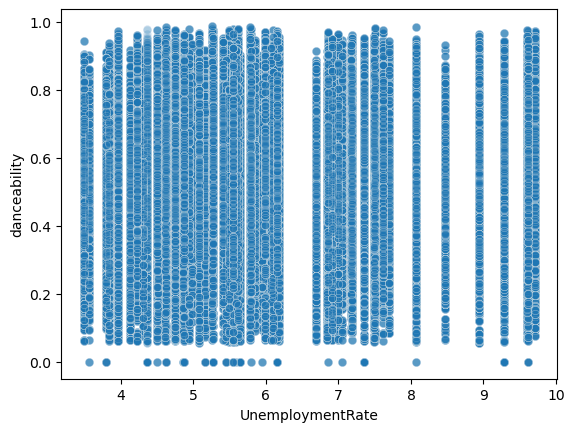

In [24]:
dance_un_graph= sns.scatterplot(cleandata, x="UnemploymentRate", y="danceability", alpha=0.1)

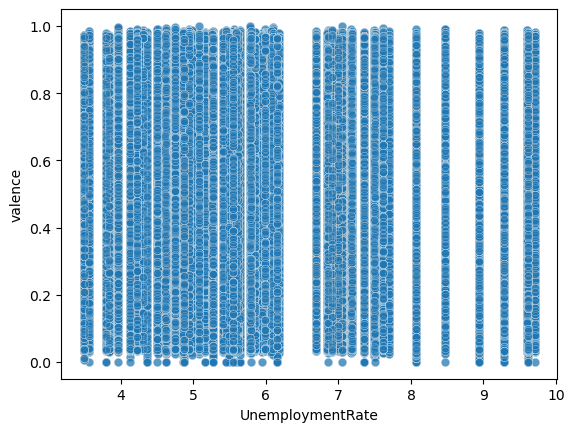

In [25]:
valence_un_graph= sns.scatterplot(cleandata, x="UnemploymentRate", y="valence", alpha=0.1)

### Data Cleaning
While looking through the different factors of calebelgut's dataset, we realized that a potential problem that caused the low correlation may be due to the fact that we did not account for each song's popularity, thus not accurately representing the music sentiment of the general population. Therefore we did further data cleaning and only considered songs above a certain popularity.**

The Popularity scale was from 0 to 100 and after looking at summary stats, we decided to filter to only songs with a rating greater or equal to 70.

In [26]:
# confirm the scale of popularity
musicdata['popularity'].unique()

array([  0,   1,   2,   3,   7,   6,   5,   4,   8,  14,  13,  11,  10,
        12,   9,  15,  19,  17,  18,  16,  20,  24,  21,  23,  22,  25,
        42,  28,  27,  37,  36,  35,  30,  26,  29,  44,  32,  33,  31,
        41,  46,  34,  45,  40,  38,  39,  54,  48,  58,  52,  47,  43,
        49,  51,  56,  55,  50,  57,  59,  66,  53,  61,  60,  62,  64,
        65,  69,  72,  63,  70,  68,  67,  71,  74,  75,  78,  81,  77,
        73,  80,  76,  79,  82,  83,  85,  84,  91,  92,  87,  86,  89,
        95,  93,  88,  90,  94,  99,  96, 100,  97])

In [27]:
#check the mean, mode and median of songs' popularity
print(musicdata['popularity'].mean())
print(musicdata['popularity'].mode())
print(musicdata['popularity'].median())

31.55660971461194
0    0
Name: popularity, dtype: int64
33.0


In [28]:
#create a dataframe just as before but with popularity>=70

# checking to see if we have NaN values
print("Number of music popularity: ", len(musicdata['popularity']))
print("Nan is present: ",\
      np.isnan(musicdata['popularity']).any())

Number of music popularity:  169909
Nan is present:  False


In [29]:
# use sql to get a data frame with danceabilty, valence, popularity, interest rate and unemployment rate
popdata= duckdb.sql("SELECT danceability, valence, popularity, musicdata.year, fedfundrate FROM\
            musicdata INNER JOIN econdata ON musicdata.year = econdata.year WHERE popularity >=70").df()
popdata= duckdb.sql("SELECT danceability, valence, popularity, popdata.year, \
        fedfundrate, UnemploymentRate FROM popdata INNER JOIN newundata\
            ON popdata.year = newundata.Year").df()
popdata

,danceability,valence,popularity,year,fedfundrate,UnemploymentRate
0,0.464,0.479,72,2013,0.09,7.358333
1,0.832,0.674,70,2013,0.09,7.358333
2,0.728,0.872,71,2013,0.09,7.358333
3,0.724,0.324,71,2014,0.12,6.158333
4,0.738,0.355,71,2014,0.12,6.158333
...,...,...,...,...,...,...
23411,0.456,0.243,74,1991,4.81,6.850000
23412,0.572,0.844,71,1991,4.81,6.850000
23413,0.452,0.805,71,1991,4.81,6.850000
23414,0.534,0.102,70,1991,4.81,6.850000


### Data Analysis

In [30]:
popdata.corr()

,danceability,valence,popularity,year,fedfundrate,UnemploymentRate
danceability,1.000000,0.412687,0.007049,0.159455,-0.081326,0.029703
valence,0.412687,1.000000,-0.051501,-0.256091,0.250243,0.062660
popularity,0.007049,-0.051501,1.000000,0.034470,-0.025550,-0.018332
year,0.159455,-0.256091,0.034470,1.000000,-0.769219,0.007697
fedfundrate,-0.081326,0.250243,-0.025550,-0.769219,1.000000,-0.056686
UnemploymentRate,0.029703,0.062660,-0.018332,0.007697,-0.056686,1.000000


Danceability and valence has a highest correlation (from 0.55 to 0.41) as what we expected but lower than what we had before filtering out songs with popularity less than 70. However, danceability has a weaker +ve correlation with Unemployment rate (from 0.04 to 0.03) and a greater -ve correlation (-0.02 to -0.08) with fedfundrate. In addition, valence has a significant higher +ve correlation with Unemployment rate (from 0.007 to 0.06)and fedfundrate (0.1 to 0.25). 

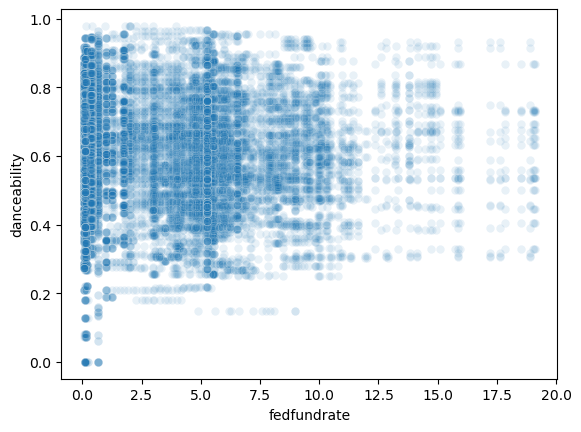

In [31]:
dance_fedfund_graph= sns.scatterplot(popdata, x="fedfundrate", y="danceability", alpha=0.1)

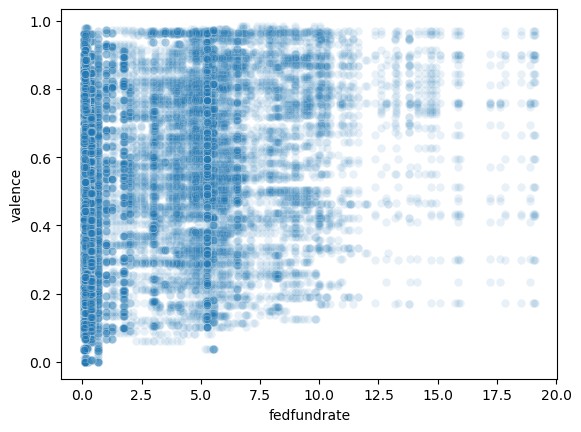

In [32]:
valence_fedfund_graph= sns.scatterplot(popdata, x="fedfundrate", y="valence", alpha=0.1)

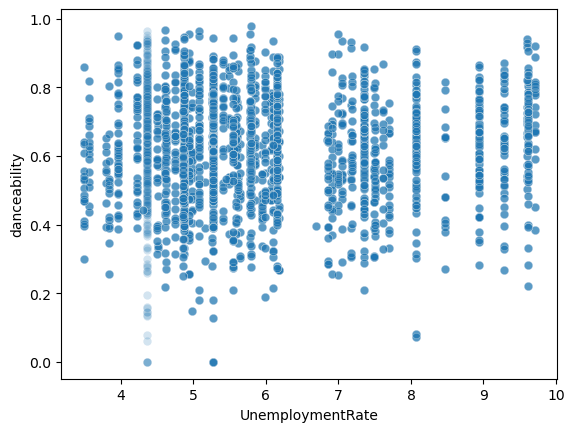

In [33]:
dance_un_graph= sns.scatterplot(popdata, x="UnemploymentRate", y="danceability", alpha=0.1)

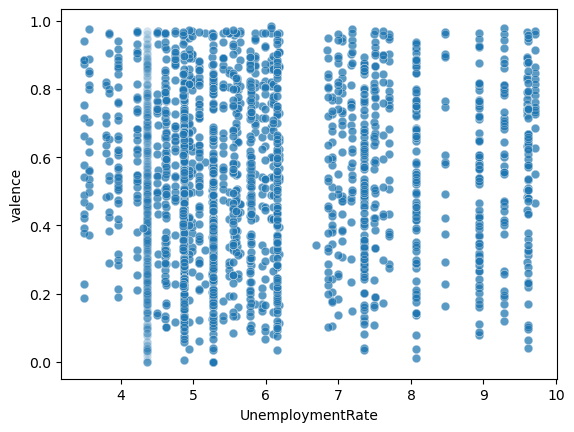

In [34]:
valence_un_graph= sns.scatterplot(popdata, x="UnemploymentRate", y="valence", alpha=0.1)

Since we notice some the number of very popular songs in each year is different, we think it could affect the corr. As such, we decide to look at the mean, median  and mode of danceability and valence for each year and compare it to the fedfundrate and unemploymentrate

In [35]:
# look at the mean, median  and mode of danceability and valence for each year correspond to the fedfundrate and unemploymentrate
analysis = duckdb.sql("SELECT AVG(danceability), MEDIAN(danceability), \
        MODE(danceability), AVG(valence), MEDIAN(valence), \
        MODE(valence), year, fedfundrate, UnemploymentRate FROM popdata GROUP BY year, fedfundrate, UnemploymentRate").df()
analysis

,avg(danceability),median(danceability),mode(danceability),avg(valence),median(valence),mode(valence),year,fedfundrate,UnemploymentRate
0,0.610241,0.6120,0.679,0.493772,0.501,0.273,2013,0.08,7.358333
1,0.629817,0.6420,0.591,0.515942,0.531,0.600,2011,0.08,8.933333
2,0.643295,0.6490,0.664,0.450888,0.438,0.548,2016,0.39,4.875000
3,0.633946,0.6335,0.718,0.529564,0.527,0.478,2008,0.97,5.800000
4,0.629822,0.6450,0.781,0.557252,0.568,0.662,2012,0.14,8.075000
...,...,...,...,...,...,...,...,...,...
601,0.534000,0.5340,0.534,0.969000,0.969,0.969,1959,2.96,5.450000
602,0.492714,0.5130,0.596,0.577619,0.446,0.796,1973,10.03,4.858333
603,0.492714,0.5130,0.596,0.577619,0.446,0.796,1973,10.01,4.858333
604,0.492714,0.5130,0.596,0.577619,0.446,0.796,1973,7.12,4.858333


In [36]:
analysis.corr()

,avg(danceability),median(danceability),mode(danceability),avg(valence),median(valence),mode(valence),year,fedfundrate,UnemploymentRate
avg(danceability),1.000000,0.961173,0.564289,0.418384,0.395189,0.122859,0.543442,0.104582,0.241061
median(danceability),0.961173,1.000000,0.554084,0.392647,0.326093,0.081601,0.547961,0.089372,0.225084
mode(danceability),0.564289,0.554084,1.000000,0.243831,0.180999,0.145145,0.248999,-0.079480,0.184821
avg(valence),0.418384,0.392647,0.243831,1.000000,0.930143,0.522473,-0.296628,0.290016,0.122696
median(valence),0.395189,0.326093,0.180999,0.930143,1.000000,0.520772,-0.212863,0.300773,0.247526
mode(valence),0.122859,0.081601,0.145145,0.522473,0.520772,1.000000,-0.159492,0.117415,0.016448
year,0.543442,0.547961,0.248999,-0.296628,-0.212863,-0.159492,1.000000,-0.223476,0.133704
fedfundrate,0.104582,0.089372,-0.079480,0.290016,0.300773,0.117415,-0.223476,1.000000,0.141998
UnemploymentRate,0.241061,0.225084,0.184821,0.122696,0.247526,0.016448,0.133704,0.141998,1.000000


### Sanity check

We decide to use another dataset to check if we can yield better corr. This dataset contains top 10000 songs from 1960 to 2023 and has valence a column.

### Data Cleaning

In [37]:
#rename the Album Release Date col, easier without space for writing SQL later
print(songdata.head())
songdata.rename(columns={"Album Release Date": "Album_Release_Date"}, inplace=True)
songdata

                              Track URI  \
0  spotify:track:1XAZlnVtthcDZt2NI1Dtxo   
1  spotify:track:6a8GbQIlV8HBUW3c6Uk9PH   
2  spotify:track:70XtWbcVZcpaOddJftMcVi   
3  spotify:track:1NXUWyPJk5kO6DQJ5t7bDu   
4  spotify:track:72WZtWs6V7uu3aMgMmEkYe   

                                Track Name  \
0  Justified & Ancient - Stand by the Jams   
1          I Know You Want Me (Calle Ocho)   
2       From the Bottom of My Broken Heart   
3         Apeman - 2014 Remastered Version   
4       You Can't Always Get What You Want   

                           Artist URI(s)      Artist Name(s)  \
0  spotify:artist:6dYrdRlNZSKaVxYg5IrvCH             The KLF   
1  spotify:artist:0TnOYISbd1XYRBk9myaseg             Pitbull   
2  spotify:artist:26dSoYclwsYLMAKD3tpOr4      Britney Spears   
3  spotify:artist:1SQRv42e4PjEYfPhS0Tk9E           The Kinks   
4  spotify:artist:22bE4uQ6baNwSHPVcDxLCe  The Rolling Stones   

                              Album URI  \
0  spotify:album:4MC0ZjNtVP1nDD5lsLx

,Track URI,Track Name,Artist URI(s),Artist Name(s),Album URI,Album Name,Album Artist URI(s),Album Artist Name(s),Album_Release_Date,Album Image URL,...,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Time Signature,Album Genres,Label,Copyrights
0,spotify:track:1XAZlnVtthcDZt2NI1Dtxo,Justified & Ancient - Stand by the Jams,spotify:artist:6dYrdRlNZSKaVxYg5IrvCH,The KLF,spotify:album:4MC0ZjNtVP1nDD5lsLxFjc,Songs Collection,spotify:artist:6dYrdRlNZSKaVxYg5IrvCH,The KLF,1992-08-03,https://i.scdn.co/image/ab67616d0000b27355346b...,...,0.0480,0.015800,0.112000,0.4080,0.504,111.458,4.0,NaN,Jams Communications,"C 1992 Copyright Control, P 1992 Jams Communic..."
1,spotify:track:6a8GbQIlV8HBUW3c6Uk9PH,I Know You Want Me (Calle Ocho),spotify:artist:0TnOYISbd1XYRBk9myaseg,Pitbull,spotify:album:5xLAcbvbSAlRtPXnKkggXA,Pitbull Starring In Rebelution,spotify:artist:0TnOYISbd1XYRBk9myaseg,Pitbull,2009-10-23,https://i.scdn.co/image/ab67616d0000b27326d73a...,...,0.1490,0.014200,0.000021,0.2370,0.800,127.045,4.0,NaN,Mr.305/Polo Grounds Music/J Records,"P (P) 2009 RCA/JIVE Label Group, a unit of Son..."
2,spotify:track:70XtWbcVZcpaOddJftMcVi,From the Bottom of My Broken Heart,spotify:artist:26dSoYclwsYLMAKD3tpOr4,Britney Spears,spotify:album:3WNxdumkSMGMJRhEgK80qx,...Baby One More Time (Digital Deluxe Version),spotify:artist:26dSoYclwsYLMAKD3tpOr4,Britney Spears,1999-01-12,https://i.scdn.co/image/ab67616d0000b2738e4986...,...,0.0305,0.560000,0.000001,0.3380,0.706,74.981,4.0,NaN,Jive,P (P) 1999 Zomba Recording LLC
3,spotify:track:1NXUWyPJk5kO6DQJ5t7bDu,Apeman - 2014 Remastered Version,spotify:artist:1SQRv42e4PjEYfPhS0Tk9E,The Kinks,spotify:album:6lL6HugNEN4Vlc8sj0Zcse,"Lola vs. Powerman and the Moneygoround, Pt. On...",spotify:artist:1SQRv42e4PjEYfPhS0Tk9E,The Kinks,2014-10-20,https://i.scdn.co/image/ab67616d0000b2731e7c53...,...,0.2590,0.568000,0.000051,0.0384,0.833,75.311,4.0,NaN,Sanctuary Records,"C © 2014 Sanctuary Records Group Ltd., a BMG C..."
4,spotify:track:72WZtWs6V7uu3aMgMmEkYe,You Can't Always Get What You Want,spotify:artist:22bE4uQ6baNwSHPVcDxLCe,The Rolling Stones,spotify:album:0c78nsgqX6VfniSNWIxwoD,Let It Bleed,spotify:artist:22bE4uQ6baNwSHPVcDxLCe,The Rolling Stones,1969-12-05,https://i.scdn.co/image/ab67616d0000b27373d927...,...,0.0687,0.675000,0.000073,0.2890,0.497,85.818,4.0,NaN,Universal Music Group,"C © 2002 ABKCO Music & Records Inc., P ℗ 2002 ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,spotify:track:3kcKlOkQQEPVwxwljbGJ5p,Kernkraft 400 (A Better Day),"spotify:artist:0u6GtibW46tFX7koQ6uNJZ, spotify...","Topic, A7S",spotify:album:2NIChqkijGw4r4Dqfmg0A3,Kernkraft 400 (A Better Day),"spotify:artist:0u6GtibW46tFX7koQ6uNJZ, spotify...","Topic, A7S",2022-06-17,https://i.scdn.co/image/ab67616d0000b273e1cafe...,...,0.0562,0.184000,0.000020,0.3090,0.400,125.975,4.0,NaN,Virgin,"C © 2022 Topic, under exclusive license to Uni..."
9995,spotify:track:5k9QrzJFDAp5cXVdzAi02f,Never Say Never - Radio Edit,spotify:artist:1ScZSjoYAihNNm9qlhzDnL,Vandalism,spotify:album:2n506u3HKN3CaEDvAjv5Ct,Never Say Never,spotify:artist:1ScZSjoYAihNNm9qlhzDnL,Vandalism,2005-10-24,https://i.scdn.co/image/ab67616d0000b273b65ad4...,...,0.0340,0.000354,0.011200,0.3380,0.767,130.978,4.0,NaN,Vicious,"C 2005 Vicious, a division of Vicious Recordin..."
9996,spotify:track:5ydeCNaWDmFbu4zl0roPAH,Groovejet (If This Ain't Love) [feat. Sophie E...,"spotify:artist:4bmymFwDu9zLCiTRUmrewb, spotify...","Spiller, Sophie Ellis-Bextor",spotify:album:20Q3pGpYiyicF32x5L8ppH,Groovejet (If This Ain't Love) [feat. Sophie E...,spotify:artist:4bmymFwDu9zLCiTRUmrewb,Spiller,2000-08-14,https://i.scdn.co/image/ab67616d0000b27342781a...,...,0.0389,0.000132,0.088900,0.3610,0.626,123.037,4.0,NaN,Defected Records,"C © 2021 Defected Records Limited, P ℗ 2021 De..."
9997,spotify:track:0zKbDrEXKpnExhGQRe9dxt,Lay Low,spotify:artist:2o5jDhtHVPhrJdv3cEQ99Z,Tiësto,spotify:album:0EYKSXXTsON8ZA95BuCoXn,Lay Low,spotify:artist:2o5jDhtH

In [38]:
songdata['Album_Release_Date'] = pd.to_datetime(songdata['Album_Release_Date'], format='%Y-%m-%d', errors='coerce')

In [39]:
songdata = duckdb.sql("SELECT *, year(Album_Release_Date) AS year FROM songdata").df()
songdata

,Track URI,Track Name,Artist URI(s),Artist Name(s),Album URI,Album Name,Album Artist URI(s),Album Artist Name(s),Album_Release_Date,Album Image URL,...,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Time Signature,Album Genres,Label,Copyrights,year
0,spotify:track:1XAZlnVtthcDZt2NI1Dtxo,Justified & Ancient - Stand by the Jams,spotify:artist:6dYrdRlNZSKaVxYg5IrvCH,The KLF,spotify:album:4MC0ZjNtVP1nDD5lsLxFjc,Songs Collection,spotify:artist:6dYrdRlNZSKaVxYg5IrvCH,The KLF,1992-08-03,https://i.scdn.co/image/ab67616d0000b27355346b...,...,0.015800,0.112000,0.4080,0.504,111.458,4.0,NaN,Jams Communications,"C 1992 Copyright Control, P 1992 Jams Communic...",1992.0
1,spotify:track:6a8GbQIlV8HBUW3c6Uk9PH,I Know You Want Me (Calle Ocho),spotify:artist:0TnOYISbd1XYRBk9myaseg,Pitbull,spotify:album:5xLAcbvbSAlRtPXnKkggXA,Pitbull Starring In Rebelution,spotify:artist:0TnOYISbd1XYRBk9myaseg,Pitbull,2009-10-23,https://i.scdn.co/image/ab67616d0000b27326d73a...,...,0.014200,0.000021,0.2370,0.800,127.045,4.0,NaN,Mr.305/Polo Grounds Music/J Records,"P (P) 2009 RCA/JIVE Label Group, a unit of Son...",2009.0
2,spotify:track:70XtWbcVZcpaOddJftMcVi,From the Bottom of My Broken Heart,spotify:artist:26dSoYclwsYLMAKD3tpOr4,Britney Spears,spotify:album:3WNxdumkSMGMJRhEgK80qx,...Baby One More Time (Digital Deluxe Version),spotify:artist:26dSoYclwsYLMAKD3tpOr4,Britney Spears,1999-01-12,https://i.scdn.co/image/ab67616d0000b2738e4986...,...,0.560000,0.000001,0.3380,0.706,74.981,4.0,NaN,Jive,P (P) 1999 Zomba Recording LLC,1999.0
3,spotify:track:1NXUWyPJk5kO6DQJ5t7bDu,Apeman - 2014 Remastered Version,spotify:artist:1SQRv42e4PjEYfPhS0Tk9E,The Kinks,spotify:album:6lL6HugNEN4Vlc8sj0Zcse,"Lola vs. Powerman and the Moneygoround, Pt. On...",spotify:artist:1SQRv42e4PjEYfPhS0Tk9E,The Kinks,2014-10-20,https://i.scdn.co/image/ab67616d0000b2731e7c53...,...,0.568000,0.000051,0.0384,0.833,75.311,4.0,NaN,Sanctuary Records,"C © 2014 Sanctuary Records Group Ltd., a BMG C...",2014.0
4,spotify:track:72WZtWs6V7uu3aMgMmEkYe,You Can't Always Get What You Want,spotify:artist:22bE4uQ6baNwSHPVcDxLCe,The Rolling Stones,spotify:album:0c78nsgqX6VfniSNWIxwoD,Let It Bleed,spotify:artist:22bE4uQ6baNwSHPVcDxLCe,The Rolling Stones,1969-12-05,https://i.scdn.co/image/ab67616d0000b27373d927...,...,0.675000,0.000073,0.2890,0.497,85.818,4.0,NaN,Universal Music Group,"C © 2002 ABKCO Music & Records Inc., P ℗ 2002 ...",1969.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,spotify:track:3kcKlOkQQEPVwxwljbGJ5p,Kernkraft 400 (A Better Day),"spotify:artist:0u6GtibW46tFX7koQ6uNJZ, spotify...","Topic, A7S",spotify:album:2NIChqkijGw4r4Dqfmg0A3,Kernkraft 400 (A Better Day),"spotify:artist:0u6GtibW46tFX7koQ6uNJZ, spotify...","Topic, A7S",2022-06-17,https://i.scdn.co/image/ab67616d0000b273e1cafe...,...,0.184000,0.000020,0.3090,0.400,125.975,4.0,NaN,Virgin,"C © 2022 Topic, under exclusive license to Uni...",2022.0
9995,spotify:track:5k9QrzJFDAp5cXVdzAi02f,Never Say Never - Radio Edit,spotify:artist:1ScZSjoYAihNNm9qlhzDnL,Vandalism,spotify:album:2n506u3HKN3CaEDvAjv5Ct,Never Say Never,spotify:artist:1ScZSjoYAihNNm9qlhzDnL,Vandalism,2005-10-24,https://i.scdn.co/image/ab67616d0000b273b65ad4...,...,0.000354,0.011200,0.3380,0.767,130.978,4.0,NaN,Vicious,"C 2005 Vicious, a division of Vicious Recordin...",2005.0
9996,spotify:track:5ydeCNaWDmFbu4zl0roPAH,Groovejet (If This Ain't Love) [feat. Sophie E...,"spotify:artist:4bmymFwDu9zLCiTRUmrewb, spotify...","Spiller, Sophie Ellis-Bextor",spotify:album:20Q3pGpYiyicF32x5L8ppH,Groovejet (If This Ain't Love) [feat. Sophie E...,spotify:artist:4bmymFwDu9zLCiTRUmrewb,Spiller,2000-08-14,https://i.scdn.co/image/ab67616d0000b27342781a...,...,0.000132,0.088900,0.3610,0.626,123.037,4.0,NaN,Defected Records,"C © 2021 Defected Records Limited, P ℗ 2021 De...",2000.0
9997,spotify:track:0zKbDrEXKpnExhGQRe9dxt,Lay Low,spotify:artist:2o5jDhtHVPhrJdv3cEQ99Z,Tiësto,spotify:album:0EYKSXXTsON8ZA95BuCoXn,Lay Low,spotify:artist:2o5jDhtHVPhrJdv

In [40]:
# no need to get popularity here in this dataset, b/c 
# this new data includes top 10000 songs
newcleandata= duckdb.sql("SELECT songdata.Year,\
        valence, UnemploymentRate FROM songdata INNER JOIN \
        newundata ON songdata.year = newundata.year").df()
newcleandata= duckdb.sql("SELECT newcleandata.year,\
        valence, UnemploymentRate, fedfundrate FROM newcleandata INNER JOIN \
        econdata ON newcleandata.year = econdata.year").df()

newcleandata

,year,Valence,UnemploymentRate,fedfundrate
0,1992.0,0.504,7.491667,2.92
1,2009.0,0.800,9.283333,0.12
2,1999.0,0.706,4.216667,5.30
3,2014.0,0.833,6.158333,0.12
4,1969.0,0.497,3.491667,8.97
...,...,...,...,...
87643,2011.0,0.162,8.933333,0.17
87644,2004.0,0.889,5.541667,1.00
87645,2006.0,0.487,4.608333,4.29
87646,2005.0,0.767,5.083333,2.28


In [41]:
# checking to see if we have NaN values
print("Number of rows in valence: ", len(newcleandata['Valence']))
print("Nan is present: ",\
      np.isnan(newcleandata['Valence']).any())

Number of rows in valence:  87648
Nan is present:  False


In [42]:
#examine the data corr 
newcleandata.corr()

,year,Valence,UnemploymentRate,fedfundrate
year,1.000000,-0.175957,0.193379,-0.730107
Valence,-0.175957,1.000000,-0.010638,0.146100
UnemploymentRate,0.193379,-0.010638,1.000000,-0.281526
fedfundrate,-0.730107,0.146100,-0.281526,1.000000


The correlation of valence and unemployment rate is different to the first data set, we have -0.01 and we have 0.06 in the previous dataset. 
The correlation between valence and fedfunddate is 0.15 and previously 0.25 (almost similar).

# Attempt 3

***Turning Point***

https://fred.stlouisfed.org/series/GDP
https://fred.stlouisfed.org/series/USPRFRMSPRTMSMNGSP


In [64]:
gdp_df = pd.read_csv("GDP.csv")
entertainment_df = pd.read_csv("USPRFRMSPRTMSMNGSP.csv")

gdp_df.head()
print(entertainment_df.dtypes)
print(entertainment_df.columns)

DATE                   object
USPRFRMSPRTMSMNGSP    float64
dtype: object
Index(['DATE', 'USPRFRMSPRTMSMNGSP'], dtype='object')


In [71]:
entertainment_df = entertainment_df.rename(columns={"USPRFRMSPRTMSMNGSP": "ENT"})
entertainment_df.tail()

,DATE,ENT
22,2019-01-01,140509.0
23,2020-01-01,100189.0
24,2021-01-01,118088.0
25,2022-01-01,149305.0
26,2023-01-01,171243.0


In [72]:
gdp_ent_df = pd.merge(gdp_df, entertainment_df, how="inner", on="DATE")
gdp_ent_df.tail()

,DATE,GDP,ENT
22,2019-01-01,21111.600,140509.0
23,2020-01-01,21727.657,100189.0
24,2021-01-01,22656.793,118088.0
25,2022-01-01,25215.491,149305.0
26,2023-01-01,27164.359,171243.0


<Axes: xlabel='GDP', ylabel='ENT'>

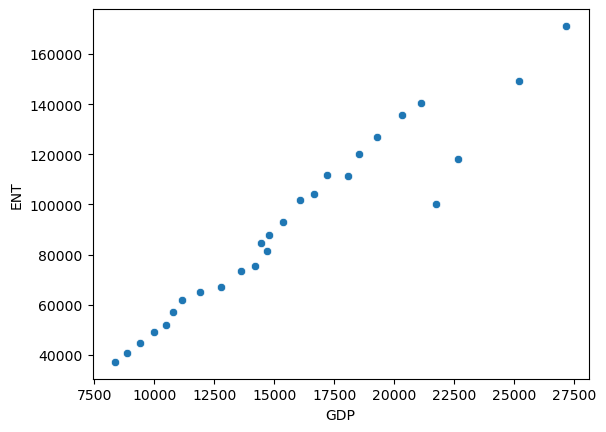

In [67]:
# simplifying the column name USPRFRMSPRTMSMNGSP to ENT
gdp_ent_df = gdp_ent_df.rename(columns={"USPRFRMSPRTMSMNGSP": "ENT"})

sns.scatterplot(data=gdp_ent_df, x="GDP", y="ENT")

In [68]:
gdp_ent_df[["GDP", "ENT"]].corr()

,GDP,ENT
GDP,1.0000,0.9625
ENT,0.9625,1.0000


### Data Discussion
The first dataset from spotify  defines the popularity of a song from the current viewership  while the second data set (top 10000 songs) defines popularity from a historical perspective (how popular was a top hit during its age). In our context, the second dataset would be better suited since we are comparing the unemployment rate or interest rate of that period to the popularity of songs of that period. Thus, comparing historical economic data with current popularity could obscure our research. 

Secondly, we soon realized that the simple variables we picked actually turned out to be not so simple. The danceability and valence curve, the interest rate and unemployment rate curve are all complex measures that oscillate and spike in unpredictable trends. Thus, we tried to fit linear relationships to the data which was difficult. This may be due to the fact that many factors contribute to music consumption and sentiment, such as, changing music taste/consumption and current event (covid for example) that fundamentally changes how people behave and thus changing music preference and taste. For example, when people are employed, they are happier and consumer happier music (shown in data set 2 where unemployment rate has a negative correlation with valence in music) but in another perspective, when people are unemployment, the need more happy music (shown in data set 1, where unemployment rate has a positive correlation with valence in music). 

Lastly, we believe that due to the complex nature of virtually all the indicators we picked, we want to inspect more variables that would strengthen our model. Variables we have in mind are genres of music, socio-economics factors, other econ factors, music taste/preferences, and so on. 

### Data Limitations¶
One limitation is that the first spotify data set defines the popularity of a song from the current viewership perspective, making it not representative of historical data. 

Another limitation is that the unemployment raw data itself is missing some values that we dropped. Although this doesn’t affect greatly since we average the months of that year’s unemployment data, this could cause the average to be higher or lower due to the dropped month’s historical trend (for example, the february month could be usually lower than january data, making the overall yearly employment higher than it actually is). 

The spotify data set and 2nd song data (top10000 songs) set that we have represent the popularity globally. Couldn't find a dataset based on only the US population.

#### Questions
- Our data (see the graphs near the beginning) are very not linear friendly, how can we transform it or make sense of it?
- Given the low correlation and linear regression coefficient, is there a better model for us to train the data?
- How can we transform our model to better fit the data?
- How and do we have to cite resources?